In [1]:
import torch
import numpy as np

import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader

from sklearn.metrics import roc_auc_score, average_precision_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from latent.utils import draw_samples_2d
from latent.transforms import RandomFeatureMatrix, EdgeLabelCreator, FullEdgeLabelCreator, OneHotFeatureMatrix
from latent.models import VGAE, Encoder
from latent.models import InnerProductDecoder, InnerProductDecoderBasis, MLPDecoder, MLPInnerProductDecoder

from latent.datasets import GNFCommunitySmall, GNFEgoSmall

In [3]:
transform = T.Compose([
    RandomFeatureMatrix(feature_dim=1024, mean=0.0, std=0.3),
    # OneHotFeatureMatrix(max_num_nodes=20),
    FullEdgeLabelCreator(),
    # EdgeLabelCreator(is_undirected=True),
    T.ToDevice('cuda')
])

dataset = GNFCommunitySmall('data/GNFCommSmall', transform=transform)
train_data = DataLoader(dataset[:90], batch_size=10, shuffle=True)
val_data = DataLoader(dataset[90:], batch_size=1, shuffle=True)

In [4]:
num_features = dataset[0].num_features
HIDDEN_CHANNELS = 32
OUT_CHANNELS = 16

device = torch.device('cuda')
encoder = Encoder(
    in_channels=num_features,
    hidden_channels=HIDDEN_CHANNELS,
    out_channels=OUT_CHANNELS,
    num_layers=2
)
# decoder = InnerProductDecoder()
# decoder = InnerProductDecoderBasis(hidden_channels=512)
# decoder = MLPDecoder(hidden_channels=512)
decoder = MLPInnerProductDecoder(hidden_channels=OUT_CHANNELS)

vgae = VGAE(
    encoder=encoder,
    decoder=decoder,
    lambda1=8.0,
    lambda2=0.0
)
vgae = vgae.to(device)
optimizer = torch.optim.Adam(vgae.parameters(), lr=0.01)

vgae

/data/home/anthony/.conda/envs/pyg/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


VGAE(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): GCNConv(1024, 32)
    )
    (conv_mu): GCNConv(32, 16)
    (conv_logstd): GCNConv(32, 16)
  )
  (decoder): MLPInnerProductDecoder(
    (mlp): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): SiLU(inplace=True)
      (2): Linear(in_features=16, out_features=16, bias=True)
    )
  )
  (bce_loss): BCELoss()
)

In [5]:
def train(model, train_data):
    model.train()

    loss = 0.0

    recon_total = 0.0
    dkl_total = 0.0

    optimizer.zero_grad()

    for data in train_data:
        z, mu, logstd = model.encode(data.x, data.edge_index)
        y_pred = model.decode(z, data.edge_label_index)
    
        recon_loss = model.recon_loss(y_pred, data.edge_label)
        dkl_loss = model.dkl_loss(mu, logstd)
        loss += recon_loss + dkl_loss

        recon_total += float(recon_loss)
        dkl_total += float(dkl_loss)

    recon_total /= len(train_data)
    dkl_total /= len(train_data)
    loss_total = recon_total + dkl_total


    loss.backward()
    optimizer.step()

    return loss_total, recon_total, dkl_total

@torch.no_grad()
def test(model, val_data):
    model.eval()

    roc_auc = 0.0
    ap = 0.0
    for data in val_data:
        z, _, _ = model.encode(data.x, data.edge_index)
        y_pred = model.decode(z, data.edge_label_index)
    
        y_true, y_pred = data.edge_label.cpu().numpy(), y_pred.cpu().numpy()

        roc_auc += roc_auc_score(y_true, y_pred)
        ap += average_precision_score(y_true, y_pred)


    return roc_auc / len(val_data), ap / len(val_data)

In [6]:
num_epochs = 1000

for epoch in range(num_epochs):
    train_loss = train(vgae, train_data)
    roc_auc, ap = test(vgae, val_data)

    if epoch % 10 == 0:
        print('Epoch {:04d}: train_loss: ({:.4f}; {:.4f}; {:.4f}); ROC_AUC: {:.4f}; AP: {:.4f}'
                .format(epoch, *train_loss, roc_auc, ap))

Epoch 0000: train_loss: (1.5954; 1.5954; 0.0000); ROC_AUC: 0.5493; AP: 0.4362
Epoch 0010: train_loss: (1.3969; 1.3969; 0.0000); ROC_AUC: 0.6829; AP: 0.5109
Epoch 0020: train_loss: (1.3897; 1.3897; 0.0000); ROC_AUC: 0.7895; AP: 0.5564
Epoch 0030: train_loss: (1.3873; 1.3873; 0.0000); ROC_AUC: 0.7411; AP: 0.5283
Epoch 0040: train_loss: (1.3868; 1.3868; 0.0000); ROC_AUC: 0.7578; AP: 0.5556
Epoch 0050: train_loss: (1.3866; 1.3866; 0.0000); ROC_AUC: 0.8170; AP: 0.5667
Epoch 0060: train_loss: (1.3865; 1.3865; 0.0000); ROC_AUC: 0.7806; AP: 0.5368
Epoch 0070: train_loss: (1.3865; 1.3865; 0.0000); ROC_AUC: 0.7662; AP: 0.5562
Epoch 0080: train_loss: (1.3864; 1.3864; 0.0000); ROC_AUC: 0.7772; AP: 0.5437
Epoch 0090: train_loss: (1.3864; 1.3864; 0.0000); ROC_AUC: 0.8181; AP: 0.5796
Epoch 0100: train_loss: (1.3864; 1.3864; 0.0000); ROC_AUC: 0.7416; AP: 0.5193
Epoch 0110: train_loss: (1.3863; 1.3863; 0.0000); ROC_AUC: 0.7682; AP: 0.5566
Epoch 0120: train_loss: (1.3862; 1.3862; 0.0000); ROC_AUC: 0.761

<AxesSubplot:>

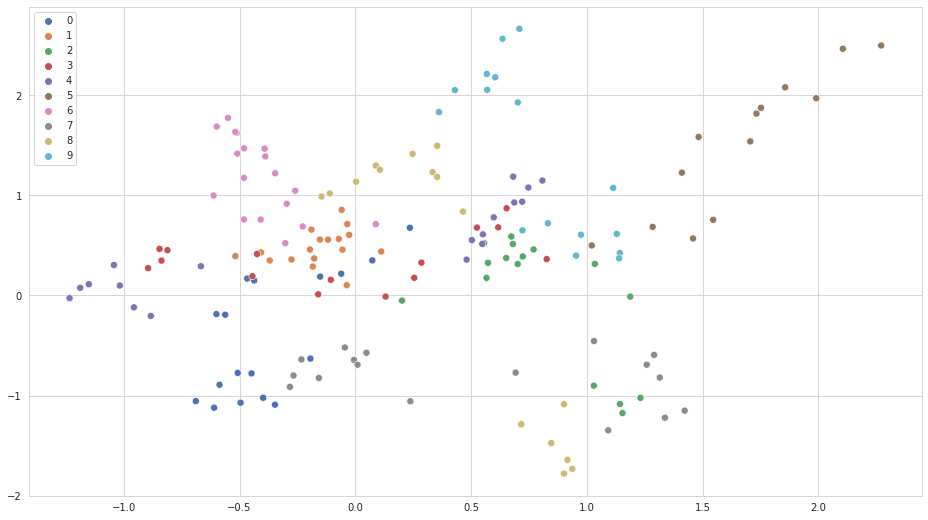

In [7]:
plt.figure(figsize=(16, 9))

Z = torch.tensor([]).cuda()
labels = np.array([])
for i, data in enumerate(val_data):
    with torch.no_grad():
        z, _, _ = vgae.encode(data.x, data.edge_index)
        Z = torch.cat([Z, z], dim=0)
        labels = np.concatenate([labels, np.ones(data.num_nodes) * i])
Z = Z.cpu().numpy()
labels = labels.astype('int')

sns.set_style('whitegrid')
sns.scatterplot(x=Z[:, 0], y=Z[:, 1], hue=labels, palette='deep', s=50)

Generated 0's: 22
Generated 1's: 267
True 1's: 90


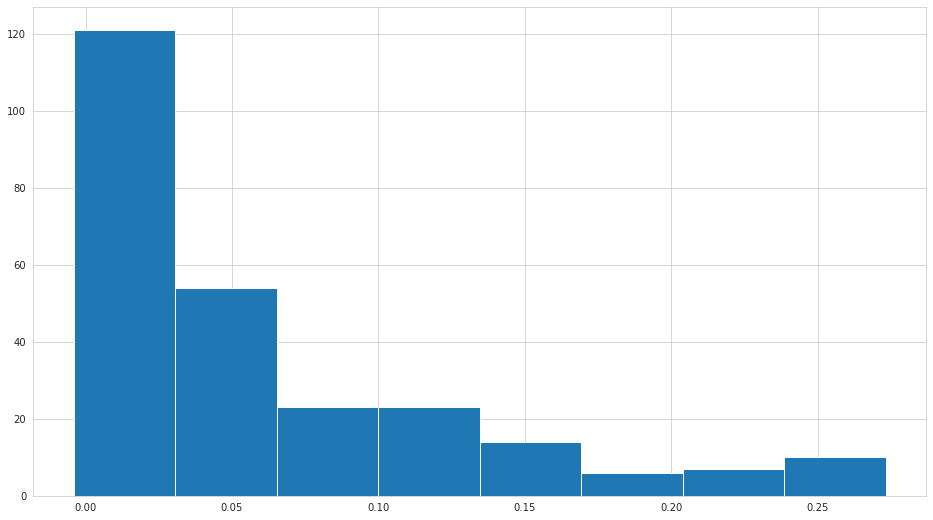

In [11]:
data = dataset[2]

with torch.no_grad():
    z, _, _ = vgae.encode(data.x, data.edge_index)
    adj = vgae.decoder.forward_all(z, sigmoid=False)
    adj = adj.cpu().numpy()

print("Generated 0's:", (adj <= 0.0).sum())
print("Generated 1's:", (adj > 0.0).sum())
print("True 1's:", int(data.edge_index.shape[1]))

plt.figure(figsize=(16, 9))
perc1 = np.percentile(adj, 5)
perc2 = np.percentile(adj, 95)

mask = (adj.ravel() > perc1) & (adj.ravel() < perc2)

_ = plt.hist(adj.ravel()[mask], bins=8)